### imports

In [29]:
!pip install tensorflow
!pip install matplotlib

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import unicodedata
import json
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

### Text Preprocessing

In [30]:
# Normalization: Handle Unicode + replace common Arabic chars + remove diacritics

def normalize_arabic(text):
    text = unicodedata.normalize('NFKD', text)

    replacements = {
        'أ': 'ا',
        'إ': 'ا',
        'آ': 'ا',
        'ى': 'ي',
        'ة': 'ه',
        'ؤ': 'و',
        'ئ': 'ي',
        'ـ': ''
    }
    for old, new in replacements.items():
        text = text.replace(old, new)

    # Remove tanween lw feeh
    text = ''.join([c for c in text if not unicodedata.combining(c)])

    return text

### Load & Prepare Data

In [31]:
# Load noisy and clean JSON text
data_limit = 1000
with open('./scrapping data/noisy_articles.json', encoding='utf-8') as f:
    noisy_data = json.load(f)[:data_limit]

with open('./scrapping data/clean_articles.json', encoding='utf-8') as f:
    clean_data = json.load(f)[:data_limit]

# print num of rows
print(len( clean_data))
# Apply normalization
x = [normalize_arabic(item["text"]) for item in noisy_data]
y = [normalize_arabic(item["text"]) for item in clean_data]

# Split into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)


1000


In [32]:
print(xtrain[1])

يعتبر مكتب شكاوي المراه التابع للمجلس القضم يللمراه بمثابه مساحه ظامنك للمراب المصريه موجود فرع له في كل محافظات مص للماسهمه في ح لالشكلات والعقبات القانونيه والاجتماعيا والنفسيه التي توجه المراه المصريه وتساندها في الحصول علي كل حقاوقها المختلفه مءن خلال مكاتبه في 27 محافظه والرقم المختصر 1ل115 وعدد اخر من ذالهوسايل كل سيده تستطيع توصيل يستفسارها ومشكلتها للرد قعليها من قبل مجموعه مكونه من 70 من الخبراء الهقانونيين والاجتماعيين والنفسيين لتدقيم الاستشاره بطرقه احترافيه، واحالتها لعد دمن لضركاء من قطاعا تانفاذ القناون او شبكه لامحاميان المتطوعين (620 يمحامي متطوع ) او الشرصكاء مقدمي الخدمات اغلاجتمعايه والنفسيه والطبيه او الخدميات الاقتصاديهغ).
ويالمكتب هو بحد اليات عمل المجلس القومي للداه في ضوء الهدف من انشاوه " لتعزيز قحوق وحريات المراه وتنشميتها وحماايتها كما ويهدف الي نشر العي بهع الاسهام ف ضمان اممضارستها وترسيخ قيم المساواه وتكافو الرص وعمد التمرييز وذلك كله بمقتضي الدستور وفي ضوء الاتفاقات والمواثيق الدوليه اتلي تصدق عليها لمصر" ( 2 من قانون 30 لسهن 2018).من بين اختصاصات المجلس

In [33]:
print(ytrain[1])

يعتبر مكتب شكاوي المراه التابع للمجلس القومي للمراه بمثابه مساحه امنه للمراه المصريه موجود فرع له في كل محافظات مصر للمساهمه في حل المشكلات والعقبات القانونيه والاجتماعيه والنفسيه التي تواجه المراه المصريه وتساندها في الحصول علي كل حقوقها المختلفه من خلال مكاتبه في 27 محافظه والرقم المختصر 15115 وعدد اخر من الوسايل كل سيده تستطيع توصيل استفسارها ومشكلتها للرد عليها من قبل مجموعه مكونه من 70 من الخبراء القانونيين والاجتماعيين والنفسيين لتقديم الاستشاره بطريقه احترافيه، واحالتها لعدد من الشركاء من قطاعات انفاذ القانون او شبكه المحامين المتطوعين (620 محامي متطوع ) او الشركاء مقدمي الخدمات الاجتماعيه والنفسيه والطبيه او الخدمات الاقتصاديه).
والمكتب هو احد اليات عمل المجلس القومي للمراه في ضوء الهدف من انشاوه " لتعزيز حقوق وحريات المراه وتنميتها وحمايتها كما يهدف الي نشر الوعي بها والاسهام في ضمان ممارستها وترسيخ قيم المساواه وتكافو الفرص وعدم التمييز وذلك كله بمقتضي الدستور وفي ضوء الاتفاقيات والمواثيق الدوليه التي تصدق عليها مصر" (م 2 من قانون 30 لسنه 2018).ومن بين اختصاصات المجلس القومي 

### Tokenization (Text Vectorization)

In [34]:
#convert the raw Arabic text into numerical representations that the model can process.

max_seq_len = 256 # Maximum number of tokens per text
vocab_size = 30000 # Limits vocabulary to top 30,000 most frequent words

vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=max_seq_len,
    standardize=None
)
vectorizer.adapt(tf.constant(xtrain + ytrain))

In [35]:
# Add start and end tokens
start_token = "[START]"
end_token = "[END]"
ytrain = [f"{start_token} {text} {end_token}" for text in ytrain]
ytest = [f"{start_token} {text} {end_token}" for text in ytest]

# Update vocabulary with special tokens
vocab = vectorizer.get_vocabulary()
# The mask token '' is likely at the beginning of the vocab. Insert your tokens after it.
if start_token not in vocab:
    # Ensure the mask token and OOV token are at the beginning
    vocab = [vocab[0],  vocab[1]] + [start_token, end_token] + vocab[2:vocab_size-2]  # vocab[0] is likely the mask token '' # vocab[1] is the OOV token '[UNK]'
    vectorizer.set_vocabulary(vocab)

### Prepare TensorFlow Dataset

In [36]:
def encode(noisy, clean):
    # Vectorize
    noisy_vec = vectorizer(tf.convert_to_tensor([noisy]))[0]
    clean_vec = vectorizer(tf.convert_to_tensor([clean]))[0]

    # Decoder inputs: clean sequence without the last token
    decoder_inputs = clean_vec[:-1]
    # Target: clean sequence without the first token
    target = clean_vec[1:]

    return {
        "encoder_inputs": noisy_vec,
        "decoder_inputs": decoder_inputs
    }, target

batch_size = 32
max_enc_len = max_seq_len
max_dec_len = max_seq_len - 1

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
dataset = dataset.map(encode, num_parallel_calls=tf.data.AUTOTUNE)

# Batch with padding
dataset = dataset.padded_batch(
    batch_size,
    padded_shapes=(
        {
            "encoder_inputs": [max_enc_len],
            "decoder_inputs": [max_dec_len]
        },
        [max_dec_len]
    ),
    padding_values=(
        {
            "encoder_inputs": tf.cast(0, tf.int64),
            "decoder_inputs": tf.cast(0, tf.int64)
        },
        tf.cast(0, tf.int64)
    ),
    drop_remainder=True
)

dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)

### Positional Encoding

In [37]:
# Positional Encoding
def positional_encoding(pos, d_model):
    angle_rads = tf.cast(tf.range(pos)[:, tf.newaxis], tf.float32) * (
        1.0 / tf.pow(
            tf.constant(10000, dtype=tf.float32),
            tf.cast(2 * (tf.range(d_model)[tf.newaxis, :] // 2), tf.float32) / tf.cast(d_model, tf.float32)
        )
    )

    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return pos_encoding[tf.newaxis, ...]

### Build Transformer Model

In [38]:
seq_len = max_seq_len
d_model = 256  # Reduced from 512 to help with small dataset
num_heads = 8
dff = 512  # Reduced from 2048
num_layers = 4
dropout_rate = 0.1

# Inputs
encoder_inputs = layers.Input(shape=(None,), dtype=tf.int64, name="encoder_inputs")
decoder_inputs = layers.Input(shape=(None,), dtype=tf.int64, name="decoder_inputs")

# Embedding + Positional Encoding
embedding_layer = layers.Embedding(vocab_size, d_model, mask_zero=True)

def positional_encoding_layer(x):
    length = tf.shape(x)[1]
    pos_enc = positional_encoding(1000, d_model)[:, :length, :]
    return x + pos_enc

# Encoder
enc_emb = embedding_layer(encoder_inputs) * tf.math.sqrt(tf.cast(d_model, tf.float32))
enc_emb = layers.Lambda(positional_encoding_layer)(enc_emb)
enc_emb = layers.Dropout(dropout_rate)(enc_emb)

encoder_output = enc_emb
for _ in range(num_layers):
    # Self attention
    attention = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )(encoder_output, encoder_output)
    attention = layers.Dropout(dropout_rate)(attention)
    encoder_output = layers.LayerNormalization(epsilon=1e-6)(encoder_output + attention)

    # Feed forward
    ffn = layers.Dense(dff, activation='gelu')(encoder_output)
    ffn = layers.Dense(d_model)(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    encoder_output = layers.LayerNormalization(epsilon=1e-6)(encoder_output + ffn)

# Decoder
dec_emb = embedding_layer(decoder_inputs) * tf.math.sqrt(tf.cast(d_model, tf.float32))
dec_emb = layers.Lambda(positional_encoding_layer)(dec_emb)
dec_emb = layers.Dropout(dropout_rate)(dec_emb)

decoder_output = dec_emb
for _ in range(num_layers):
    # Self attention
    self_attention = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )(decoder_output, decoder_output)
    self_attention = layers.Dropout(dropout_rate)(self_attention)
    decoder_output = layers.LayerNormalization(epsilon=1e-6)(decoder_output + self_attention)

    # Cross attention
    cross_attention = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )(decoder_output, encoder_output)
    cross_attention = layers.Dropout(dropout_rate)(cross_attention)
    decoder_output = layers.LayerNormalization(epsilon=1e-6)(decoder_output + cross_attention)

    # Feed forward
    ffn = layers.Dense(dff, activation='gelu')(decoder_output)
    ffn = layers.Dense(d_model)(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    decoder_output = layers.LayerNormalization(epsilon=1e-6)(decoder_output + ffn)

# Final Output Layer
final_output = layers.Dense(vocab_size)(decoder_output)

# Build Model
model = tf.keras.Model(
    inputs={"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    outputs=final_output
)

In [39]:
print(len(vectorizer.get_vocabulary()))


30000


### Compile and Train Model

In [40]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=False
)

optimizer = tf.keras.optimizers.Adam(
    lr_schedule,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Train
history = model.fit(dataset, epochs=20)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 109s 991ms/step - accuracy: 0.1674 - loss: 9.9506
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 947ms/step - accuracy: 0.2078 - loss: 9.2480
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 936ms/step - accuracy: 0.2078 - loss: 8.7170
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 978ms/step - accuracy: 0.2078 - loss: 8.2852
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 956ms/step - accuracy: 0.2078 - loss: 7.9347
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 933ms/step - accuracy: 0.2094 - loss: 7.6443
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 977ms/step - accuracy: 0.2208 - loss: 7.3990
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 958ms/step - accuracy: 0.2356 - loss: 7.1907
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 935ms/step - accuracy: 0.2406 - loss: 7.0112
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 949ms/step - accuracy: 0.2418 - loss: 6.8528
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 972ms/step - accuracy: 0.2433 - loss: 6.7131
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4

###  Plot Training Results

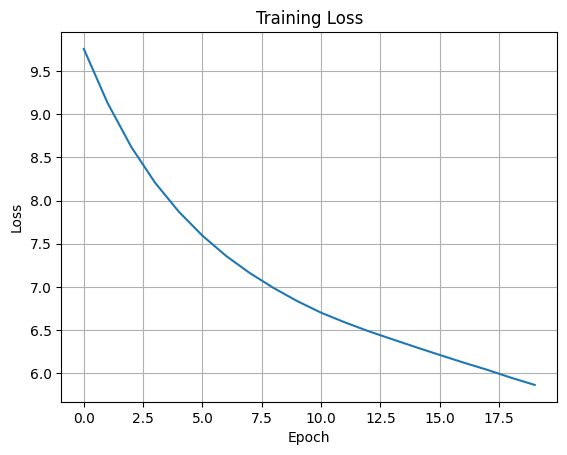

In [41]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [42]:
def correct_text(input_text, max_length=50):
    # Normalize input
    normalized_input = normalize_arabic(input_text)

    # Vectorize input
    encoder_input = vectorizer(tf.convert_to_tensor([normalized_input]))

    # Initialize decoder input with start token
    start_token_id = vectorizer([start_token]).numpy()[0][0]
    decoder_input = tf.expand_dims([start_token_id], 0)

    output_ids = []

    for i in range(max_length):
        # Predict next token
        predictions = model({
            "encoder_inputs": encoder_input,
            "decoder_inputs": decoder_input
        }, training=False)

        # Get most likely token
        predicted_id = tf.argmax(predictions[:, -1, :], axis=-1).numpy()[0]

        # Stop if we predict the end token
        if predicted_id == vectorizer([end_token]).numpy()[0][0]:
            break

        # Append predicted token to output
        output_ids.append(predicted_id)

        # Update decoder input for next step
        decoder_input = tf.concat([
            decoder_input,
            tf.expand_dims([predicted_id], 0)
        ], axis=-1)

    # Convert token IDs to text
    vocab = vectorizer.get_vocabulary()
    corrected_text = ' '.join([vocab[token_id] for token_id in output_ids])

    return corrected_text

# Test the model
noisy_sentence = "ھذە الجملت فیھا اخطاء"
corrected_sentence = correct_text(noisy_sentence)

print("Noisy sentence     :", noisy_sentence)
print("Corrected sentence :", corrected_sentence)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Noisy sentence     : ھذە الجملت فیھا اخطاء
Corrected sentence : قال الدكتور احمد عبد الفتاح                                             
